In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
figsize(7, 7)

Populating the interactive namespace from numpy and matplotlib


# PyTorch

"Tensors and Dynamic neural networks in Python with strong GPU acceleration"

- like Matlab or Numpy, but with GPU support
- automatic, dynamic differentiation and gradient descent
- some frameworks for neural networks

# SIMPLE COMPUTATIONS

In [2]:
# simple "tensors" (multidimensional numerical arrays) in Torch

import torch
data = torch.rand(256, 256)
print(data)

tensor([[0.3307, 0.6175, 0.4339,  ..., 0.1160, 0.7018, 0.3328],
        [0.7126, 0.3097, 0.0193,  ..., 0.2221, 0.3638, 0.2307],
        [0.8590, 0.7884, 0.1826,  ..., 0.4990, 0.4524, 0.0525],
        ...,
        [0.5371, 0.0717, 0.6199,  ..., 0.0673, 0.4926, 0.3311],
        [0.7726, 0.7256, 0.0145,  ..., 0.9978, 0.1541, 0.0611],
        [0.8108, 0.0522, 0.0348,  ..., 0.4400, 0.1253, 0.3583]])


In [3]:
# a pointless GPU computation

if torch.has_cuda:
    data = torch.rand(256, 256).cuda()
    out = data
    for i in range(100):
        out = torch.mm(data, out)
        out /= out.norm()
    imshow(out.cpu().numpy())
else:
    print("CUDA not available")

CUDA not available


# PyTorch 

- standard set of numerical operations
- similar primitives to Numpy, Matlab
- operations run on CPU and GPU
- GPU operations use CUDA, cuDNN, some third party kernels
- direct binding: you call a numerical function, it calls the kernel

# AUTOMATIC DIFFERENTIATION

In [4]:
def tshow(image, **kw):
    if image.ndimension()==2:
        imshow(image.detach().cpu().numpy(), **kw)
    elif image.ndimension()==3:
        if image.shape[0]==1:
            tshow(image[0])
        else:
            imshow(image.detach().cpu().permute(1, 2, 0).numpy(), **kw)
    elif image.ndimension()==4:
        tshow(image[0])

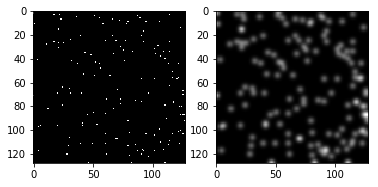

In [5]:
def generate_pair():
    image = (torch.rand((128, 128)) > 0.99).type(torch.float)
    import scipy.ndimage as ndi
    target = torch.tensor(ndi.gaussian_filter(image.numpy(), 2.0))
    return image, target

image, target = generate_pair()
subplot(121); tshow(image); subplot(122); tshow(target)

# 2D Convolutions

In [6]:
import torch.nn.functional as F

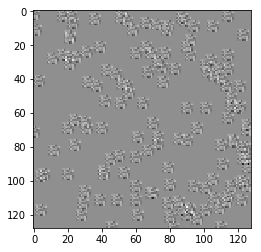

In [7]:
x = image[None, None, :, :]
y = target[None, None, :, :]

w = torch.randn(1, 1, 7, 7)
w.requires_grad = True
x.requires_grad = True

y_predicted = F.conv2d(x, w, padding=3)

tshow(y_predicted)

In [8]:
w

tensor([[[[-0.2179,  1.1922, -1.5967, -2.4425,  0.2748, -0.2562, -0.5234],
          [-0.6552,  1.3058,  0.0209,  0.2611,  0.1027,  1.5229, -0.8749],
          [-1.2187,  1.3558,  0.4368,  1.1189,  0.2302, -0.5490,  0.6791],
          [-0.3221, -0.5090, -0.6162, -0.7898, -0.5212,  1.0309, -1.1551],
          [-0.4207, -1.1585,  0.7804,  0.5546,  1.1854,  0.2396,  0.2582],
          [ 1.4224,  0.3302,  0.0919, -1.0223, -0.0385,  1.4317, -0.7480],
          [ 0.2927,  0.0691, -1.3644,  1.1374,  0.4076,  0.8086,  0.6358]]]],
       requires_grad=True)

In [9]:
w.grad

# Computing the Error

In [10]:
err = ((y_predicted - y)**2).sum()
print(err)

err.backward(retain_graph=True)
print(w.grad)

tensor(5419.7490, grad_fn=<SumBackward0>)
tensor([[[[ -69.1051,  320.8156, -442.0571, -672.4368,   65.9947,  -67.5986,
           -141.9771],
          [-155.6079,  365.7351,   -2.7701,   79.2684,   41.9277,  422.8547,
           -235.8171],
          [-314.7597,  367.0608,  119.5343,  314.8057,   61.5713, -137.2444,
            180.4208],
          [ -80.0234, -147.6856, -200.7731, -234.6606, -163.4970,  276.7699,
           -309.6857],
          [-116.2176, -306.8345,  203.4817,  131.3338,  303.6224,   63.8498,
             61.8238],
          [ 412.6524,   90.4075,   28.6304, -287.1292,   -5.3587,  394.1716,
           -213.9728],
          [  81.9760,   21.7218, -368.3131,  322.1759,  124.5357,  231.8755,
            175.4593]]]])


In [11]:
from graphviz import Digraph
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='9',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12", rankdir="LR"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

# Computation Graph

{140627679949520: 'w', 140627679920992: 'x'}


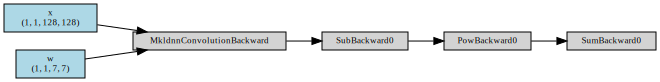

In [12]:
make_dot(err, dict(w=w, x=x))

# PyTorch Autograd Summary

- Tensors $\rightarrow$ Variables
- PyTorch keeps track of derivatives
- computation graphs can be completely dynamic
- propagate derivatives backwards using `x.backward()`
- access gradients using `x.grad`

# SIMPLE LEARNING

In [13]:
from torch import optim
import torch.nn.functional as F

x, y = generate_pair()
w = torch.randn(1, 1, 7, 7)
w.requires_grad = True

for i in range(5000):
    if w.grad is not None: w.grad.fill_(0)
    y_predicted = F.conv2d(x[None, None, :, :], w, padding=3)
    err = ((y_predicted - y[None, None, :, :])**2).sum()
    err.backward()
    w.data -= 1e-5 * w.grad
    if i%1000==0: print(f"{i:6d} {err.item():.3f}")

     0 10277.744
  1000 16.298
  2000 0.177
  3000 0.150
  4000 0.150


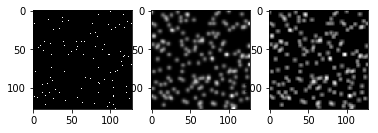

In [14]:
# input, desired output, learned output via gradient descent
subplot(131); tshow(x); subplot(132); tshow(y); subplot(133); tshow(y_predicted)

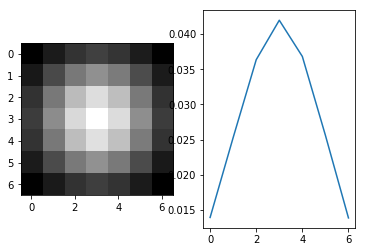

In [15]:
subplot(121); tshow(w); subplot(122); plot(w[0, 0, 3, :].detach().numpy())

# Learning a Linear Filter with Layers

- above example used gradient descent using completely functional computations
- a `Conv2d` layer is the same as a linear filter
- let's see whether we can learn this using PyTorch
- this uses all the components we need to train more complex models in PyTorch

In [16]:
from torch import nn, optim

# the "model" is just a single convolutional layer
model = nn.Conv2d(1, 1, (17, 17), padding=8)

# the loss is MSE loss
criterion = nn.MSELoss()

In [17]:
x, y = generate_pair()

for i in range(5000):
    
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    
    y_predicted = model(x[None, None, :, :])
    
    loss = criterion(y[None, None, :, :], y_predicted)
    if i%1000==0: print(i, loss.item())
    loss.backward()
    
    optimizer.step()

0 0.0054459888488054276
1000 6.982936611166224e-05
2000 6.19554111835896e-06
3000 4.777613412443316e-06
4000 4.739039468404371e-06


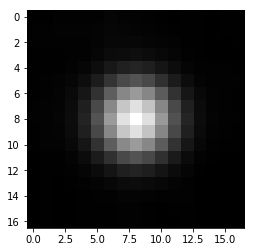

In [18]:
# display the learned kernel
parameters = list(model.parameters())
imshow(parameters[0].data[0,0].cpu().numpy())

# Torch "Modules" / "Layers"

In [19]:
import torch.functional as F

class Linear(nn.Module):
    def __init__(self, ninput, noutput):
        self.weights = Parameter(torch.randn(noutput, ninput))
    def forward(self, x):
        return F.linear(x, self.weights)
    # NB: no "backward" method needed

# Composition of Torch Layers

In [20]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# SHAPE INFERENCE, INPUT, REORDER

# Manual Sizes

Keeping track of depths can be complicated in the presence of padding and reshaping.

In [21]:
model = nn.Sequential(
    nn.Conv2d(1, 8, 3),
    nn.ReLU(),
    nn.Conv2d(8, 16, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2304, 10)
)
model(torch.randn(1, 1, 16, 16)).shape

torch.Size([1, 10])

# Shape Inference

Shape inference simplifies this.

In [22]:
from torchmore import layers, flex
model = nn.Sequential(
    flex.Conv2d(8, 3),
    nn.ReLU(),
    flex.Conv2d(16, 3),
    nn.ReLU(),
    nn.Flatten(),
    flex.Linear(10)
)
model(torch.randn(1, 1, 16, 16)).shape

torch.Size([1, 10])

# How `flex` works

`flex` simply delays allocation of layers until the first forward pass.

In [23]:
model = nn.Sequential(
    flex.Conv2d(16, 3),
    nn.ReLU(),
    nn.Flatten(),
    flex.Linear(10)
)
model

Sequential(
  (0): Flex:None
  (1): ReLU()
  (2): Flatten()
  (3): Flex:None
)

In [24]:
with torch.no_grad():
    model.forward(torch.randn(1, 1, 64, 64))
model

Sequential(
  (0): Flex:Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten()
  (3): Flex:Linear(in_features=61504, out_features=10, bias=True)
)

# Converting to Standard Models

`flex.freeze` turns a flex model into a standard model.

In [25]:
flex.freeze(model)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten()
  (3): Linear(in_features=61504, out_features=10, bias=True)
)

# Generic `Flex` Modules

In [26]:
model = nn.Sequential(flex.Flex(lambda x: nn.Conv2d(x.size(1), 10, 3)))
print(model)
model.forward(torch.rand(1, 1, 8, 8))
print(model)
flex.freeze(model)
print(model)

Sequential(
  (0): Flex:None
)
Sequential(
  (0): Flex:Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
)
Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
)


# Building Abstractions

Clever use of Python syntax makes it easy to build complex models out of building blocks.

In [27]:
def conv2d(d, r=3, mp=None):
    result = [
        flex.Conv2d(16, r, padding=r//2),
        flex.BatchNorm2d(),
        nn.ReLU()
    ]
    if mp is not None: result += [nn.MaxPool2d(mp)]
    return result

model = nn.Sequential(
    *conv2d(16),
    *conv2d(32, mp=2)
)
flex.shape_inference(model, (1, 1, 64, 64))
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Input Layers

Inputs to models need to have a particular order of the axes, size requirements, device requirements, and value ranges. The `Input` layer helps keeping track of these and enforcing them.

In [28]:
model = nn.Sequential(
    layers.Input(assume="BDHW", sizes=((1, 256), 3, None, None), dtype=torch.float32),
    *conv2d(16, 7, mp=2),
    *conv2d(32, mp=2)
)

flex.shape_inference(model, (1, 3, 64, 64))
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 None cpu ((1, 256), 3, None, None))
  (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# `Fun` and `Reorder`

- `Fun` allows us to put simple functional expressions inside a network
- `Reorder` allows axis permutation with more symbolic names

In [30]:
model = nn.Sequential(
    layers.Input("BDHW", sizes=((1, 256), 3, None, None), dtype=torch.float32),
    *conv2d(16, 7, mp=2),
    *conv2d(32, mp=2),
    layers.Fun("lambda x: x.sum(1)"),
    layers.Reorder("BDL", "LBD")
)

flex.shape_inference(model, (1, 3, 64, 64))
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 None cpu ((1, 256), 3, None, None))
  (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Fun None lambda x: x.sum(1)
  (10): Reorder("BDL", "LBD")
)

# Wrapper-Style Modules

Some common modules "wrap around" others; these occur in Resnet, U-net, etc.

In [32]:
model = nn.Sequential(
    layers.Parallel(
        flex.Conv2d(8, 11, padding=5),
        flex.Conv2d(64, 3, padding=1)
    ),
    nn.ReLU(),
    flex.Conv2d(32, 3, padding=1)
)
flex.shape_inference(model, (1, 1, 64, 64))
model

Sequential(
  (0): Parallel(
    (0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): ReLU()
  (2): Conv2d(72, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Wrapper Style Modules

- `Parallel(*args)` -- run modules in parallel and concatenate results
- `Additive(*args)` -- run modules in parallel and add results
- `KeepSize(*args)` -- run contained module and resize output to input size
- `UnetLayer(...,sub=...)` -- run `MaxPool2d` down, down module, `TransposeConv2d` up

# Summary of Torch "Modules" and Training

- training uses modules, criteria, and optimizers
- modules (nn.Module) keep track of parameters and compute in the forward method
- criteria compute the differences between two outputs and return a scalar loss
- optimizers initiate gradient computation and then update the model parameters
- `torchmore` provides shape inference and some convenience modules

# PYTORCH VS OTHERS

# Common Deep Learning Frameworks

Primary:

- TensorFlow
- PyTorch (old: Torch)
- Caffe 2 (old: Caffe)
- mxnet
- Chainer

Derived:

- Keras
- Theano

# TensorFlow

- superficially like PyTorch, but internally very different
- core is a dataflow language, completely separate from Python

Issues:
- tons of code between you and the kernels
- many custom written Google kernels
- memory hungry
- RNN support is worse

# PyTorch

Issues:

- Python multithreading is poor, therefore...
- limited ability to write high performance multi-GPU code

Potential Solutions:
- port to IronPython (C#, .NET)
- future, better Python JIT/compilers

# Future?

- both PyTorch and Tensorflow have serious limitations
- either they will substantially, or new frameworks will come around